# **Detección de anomalías en el dataset *Elliptic***
---

Víctor Pérez Cano (victor.perezcano@estudiante.uam.es)

---

Algoritmos de detección de anomalías aplicados al dataset de transacciones de Bitcoin *Elliptic*

---
---


# **1. Preparación**
---

In [1]:
#@title ### Instalación de librerías

!pip install matplotlib
!pip install scikit-learn
!pip install networkx

import torch

!pip install torch_geometric

# Optional dependencies:
if torch.cuda.is_available():
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
else:
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.1/508.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 1.2 MB/s eta 0:00:00


# **2. Construcción del dataset**
---

## 2.1 Obtener CSVs

### Montar la unidad de Drive

In [2]:
from google.colab import drive
from os import path as osp

drive.mount('/content/gdrive',force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks/TFG Infor'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/TFG Infor



## 2.2. Creación de dataframes de Pandas a partir de los CSVs

In [3]:
import pandas as pd
import numpy as np

df_features = pd.read_csv("./Datasets/Elliptic Bitcoin Dataset/elliptic_txs_features.csv", header=None)
df_classes = pd.read_csv("./Datasets/Elliptic Bitcoin Dataset/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./Datasets/Elliptic Bitcoin Dataset/elliptic_txs_edgelist.csv")

class_mapping = {
    '1': 1,
    '2': 0,
    'unknown': 2
}

df_classes['class'] = df_classes['class'].map(class_mapping)
df_transactions = pd.merge(df_classes, df_features, left_on='txId', right_on=df_features.columns[0], how='inner').drop(df_features.columns[0], axis=1)
df_transactions.columns.values[2] = 'timestep'

In [4]:
df_transactions

,txId,class,timestep,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,230425980,2,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,2,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,2,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,2,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,2,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,2,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


## 2.3. Encontrar proporción de clases positivas en el *dataset*

In [5]:
import numpy as np

df_known = df_transactions[df_transactions['class'].isin([0, 1])]
test_flags = np.array(df_known['class'])
test_flags.sum() / len(test_flags)

0.09760759384932566

In [6]:
positive_prop = 0.08    # Para hacer predicciones más conservadoras

## 2.4. Visualización de los datos

t-SNE es un algoritmo de reducción de dimensiones ideal para la visualización de los datos, pero no tanto para su análisis.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne_data(feature_matrix, labels, rs=33):
    tsne = TSNE(n_components=3, random_state=rs, n_jobs=-1)
    reduced_features = tsne.fit_transform(feature_matrix)

    sns.set(style="whitegrid")
    plt.style.use('Solarize_Light2')
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(reduced_features[np.where(labels == 0), 0], reduced_features[np.where(labels == 0), 1], reduced_features[np.where(labels == 0), 2], marker='o', color='g', linewidth=1, alpha=0.6, label='Lícita')
    ax.scatter(reduced_features[np.where(labels == 1), 0], reduced_features[np.where(labels == 1), 1], reduced_features[np.where(labels == 1), 2], marker='o', color='r', linewidth=1, alpha=0.8, label='Ilícita')
    plt.legend()
    plt.show()

    return reduced_features

tsne_reduced_features = visualize_tsne_data(df_transactions.iloc[:,3:], df_transactions['class'])

In [ ]:
sns.set(style="whitegrid")
#plt.style.use('Solarize_Light2')
plt.figure(figsize=(12, 8))
plt.scatter(tsne_reduced_features[np.where(df_transactions['class'] == 0), 0], tsne_reduced_features[np.where(df_transactions['class'] == 0), 1], marker='o', color='g', linewidth=1, alpha=0.6, label='Lícita')
plt.scatter(tsne_reduced_features[np.where(df_transactions['class'] == 1), 0], tsne_reduced_features[np.where(df_transactions['class'] == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Ilícita')
plt.legend()
plt.show()

## Algunas definiciones útiles

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(predictions, k=None, title=None):
    sns.heatmap(confusion_matrix(test_flags, predictions), annot=True, fmt='d',
                xticklabels=['Inlier', 'Outlier'],
                yticklabels=['Lícito', 'Ilícito'])
    if title is not None:
        plt.title(title)
    elif k is not None:
        plt.title(f'Matriz de confusión de LOF con k={k}')
    else:
        plt.title(f'Matriz de confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    plt.show()


# **3. *Feature Engineering***
---

## 3.1. Reducción de dimensiones

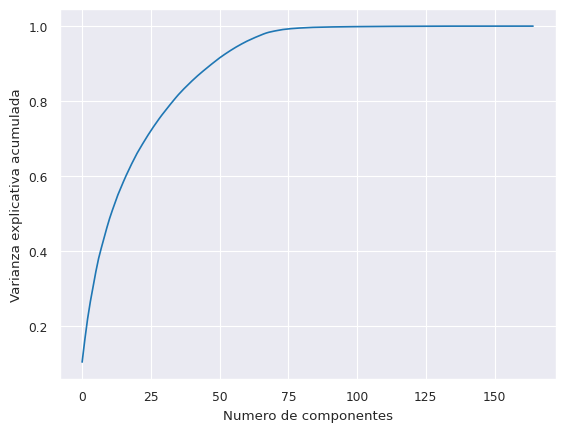

In [ ]:
#@title ### *Principal Componente Analysis (PCA)*

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def compute_pca(feature_matrix, plot=True):
    pca = PCA()
    reduced_features = pca.fit_transform(feature_matrix)
    expl = pca.explained_variance_ratio_

    if plot:
        plt.plot(np.cumsum(expl))
        plt.xlabel('Numero de componentes')
        plt.ylabel('Varianza explicativa acumulada')
        plt.show()

    return reduced_features, expl

pca_reduced_feat, _ = compute_pca(df_transactions.iloc[:,3:])

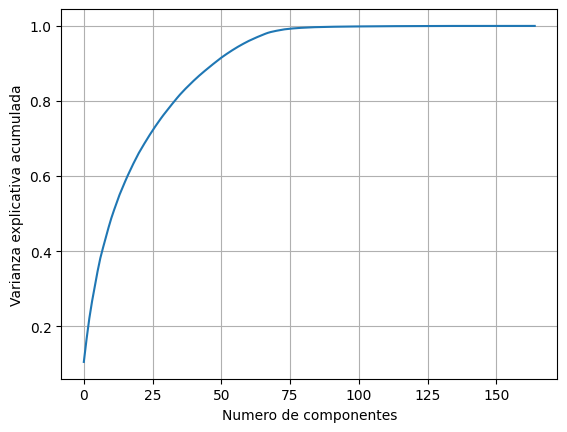

In [ ]:
#@title ### *Truncated Singular Value Decomposition (Truncated SVD)*

from sklearn.decomposition import TruncatedSVD

def compute_tsvd(feature_matrix, plot=True):
    svd = TruncatedSVD(n_components=feature_matrix.shape[1])
    reduced_features = svd.fit_transform(feature_matrix)
    expl = svd.explained_variance_ratio_

    if plot:
        plt.plot(np.cumsum(expl))
        plt.xlabel('Numero de componentes')
        plt.ylabel('Varianza explicativa acumulada')
        plt.grid()
        plt.show()

    return reduced_features, expl

tsvd_reduced_feat, _ = compute_tsvd(df_transactions.iloc[:,3:])

Se puede comprobar que el resultado es el mismo porque para los datos, ambos algoritmos de reducción de dimensiones (PCA y TruncatedSVD) son equivalentes.

Me quedo con las primeras 75 *features* con mayor varianza.

In [ ]:
reduced_feature_matrix = pca_reduced_feat[:,:75]

## 3.2. **Información Mutua** de cada *Feature* con respecto a la clase

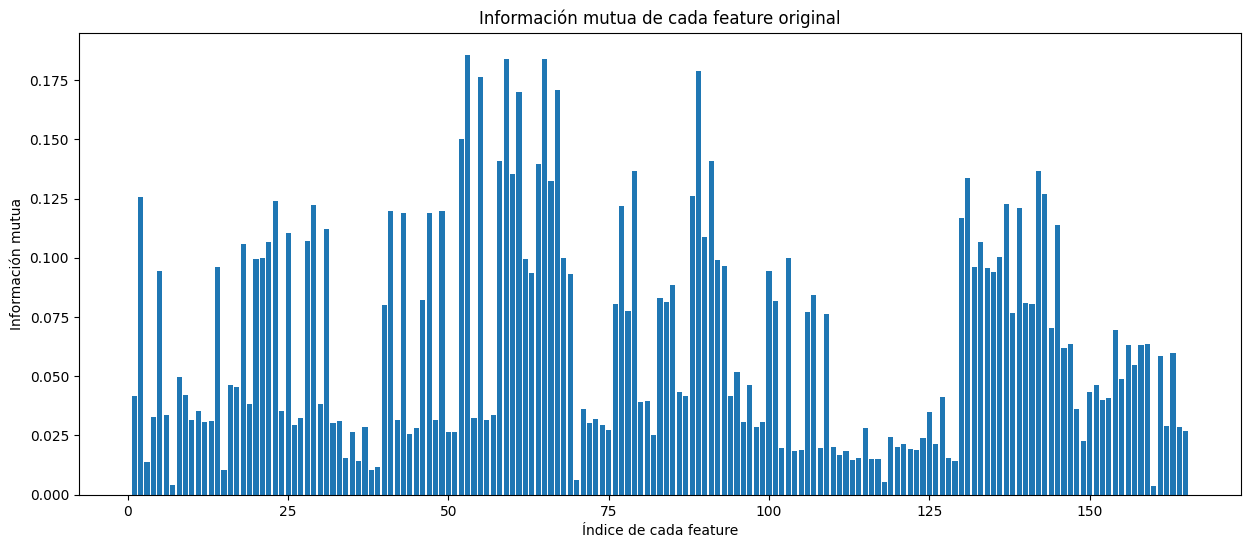

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

feat = df_known.drop(['txId', 'timestep', 'class'], axis=1)
mis = mutual_info_classif(feat, df_known['class'])

plt.figure(figsize = (15,6))
plt.bar([i+1 for i in range(feat.shape[1])], mis)
plt.xlabel("Índice de cada feature")
plt.ylabel("Información mutua")
plt.title("Información mutua de cada feature original")
plt.show()


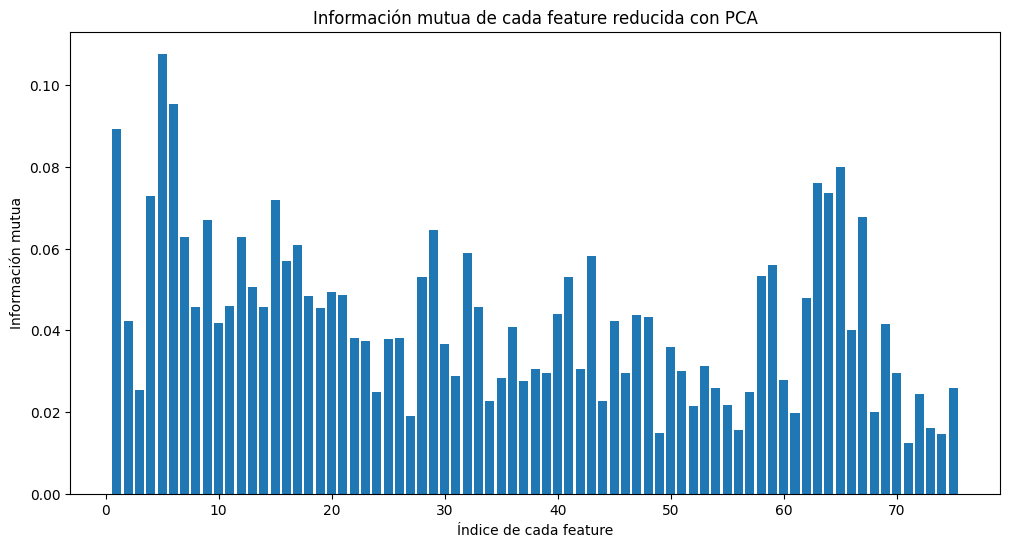

In [ ]:

mis = mutual_info_classif(reduced_feature_matrix[df_known.index], df_known['class'])

plt.figure(figsize = (12,6))
plt.bar([i+1 for i in range(reduced_feature_matrix.shape[1])], mis)
plt.xlabel("Índice de cada feature")
plt.ylabel("Información mutua")
plt.title("Información mutua de cada feature reducida con PCA")
plt.show()


Se podría realizar una selección individual de *features* pero los gráficos anteriores muestran que la información mutua de cada *feature* con la clase de una transacción, es decir su importancia a la hora de decidir si la transacción es lícita o no, no es muy alta, siendo la IM más alta un poco mayor que 0.175.

Por tanto se puede deducir que, de obtener una mejora al realizar selección de *features*, esta sería una mejora muy pequeña.

# **4. *Local Outlier Factor (LOF)***
---

## Primeras pruebas para elegir el mejor valor de $K$


#### Pruebas solo con las features locales

  0%|          | 0/16 [00:00<?, ?it/s]

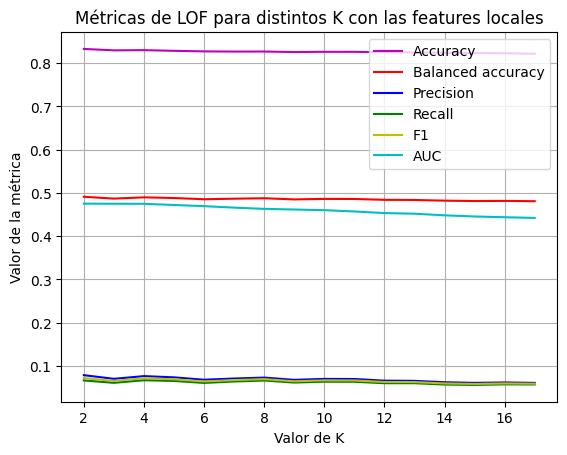

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from tqdm.notebook import tqdm

X = df_transactions.drop(['txId', 'timestep', 'class'], axis=1)
X = X.iloc[:,:94]

local_features_accs = dict()
local_features_baccs = dict()
local_features_precs = dict()
local_features_recs = dict()
local_features_f1s = dict()
local_features_aucs = dict()
local_features_preds = dict()
local_features_lofs = dict()

for k in tqdm(range(2,18)):
    clf = LocalOutlierFactor(n_neighbors=k, contamination=positive_prop)
    all_predicted_flags = clf.fit_predict(X)
    all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                                np.where(all_predicted_flags == 1, 0, all_predicted_flags))
    predicted_flags = all_predicted_flags[df_known.index]
    local_features_preds[k] = predicted_flags
    local_features_lofs[k] = -clf.negative_outlier_factor_[df_known.index]
    local_features_accs[k] = accuracy_score(test_flags,predicted_flags)
    local_features_baccs[k] = balanced_accuracy_score(test_flags,predicted_flags)
    local_features_precs[k] = precision_score(test_flags,predicted_flags)
    local_features_recs[k] = recall_score(test_flags,predicted_flags)
    local_features_f1s[k] = f1_score(test_flags,predicted_flags)
    local_features_aucs[k] = roc_auc_score(test_flags,local_features_lofs[k])

plt.figure(figsize=(6,6))
plt.plot(list(local_features_accs.keys()), list(local_features_accs.values()), color='m', label='Accuracy')
plt.plot(list(local_features_baccs.keys()), list(local_features_baccs.values()), color='r', label='Balanced accuracy')
plt.plot(list(local_features_precs.keys()), list(local_features_precs.values()), color='b', label='Precision')
plt.plot(list(local_features_recs.keys()), list(local_features_recs.values()), color='g', label='Recall')
plt.plot(list(local_features_f1s.keys()), list(local_features_f1s.values()), color='y', label='F1')
plt.plot(list(local_features_aucs.keys()), list(local_features_aucs.values()), color='c', label='AUC')
plt.xlabel('Valor de K')
plt.xticks(range(2,18,2))
plt.ylabel('Valor de la métrica')
#plt.title('Métricas de LOF para distintos K con las features locales')
plt.legend()
plt.savefig(f'./Plots/OutlierDetection/LOF_metrics.eps',format='eps',bbox_inches='tight')
plt.show()
plt.close()



#### Pruebas con todas las features

  0%|          | 0/16 [00:00<?, ?it/s]

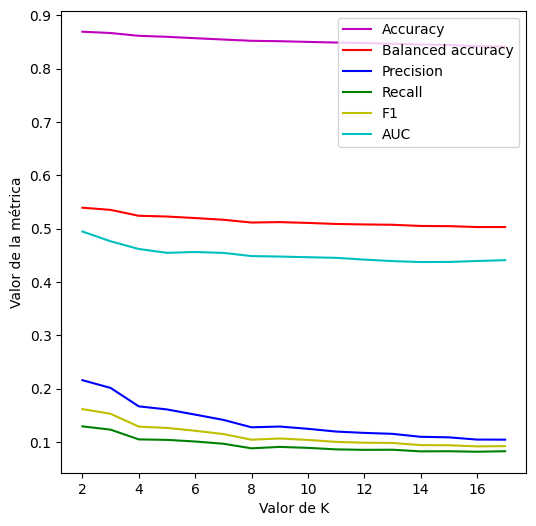

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from tqdm.notebook import tqdm

X = df_transactions.drop(['txId', 'timestep', 'class'], axis=1)

all_features_accs = dict()
all_features_baccs = dict()
all_features_precs = dict()
all_features_recs = dict()
all_features_f1s = dict()
all_features_aucs = dict()
all_features_preds = dict()
all_features_lofs = dict()

for k in tqdm(range(2,18)):
    clf = LocalOutlierFactor(n_neighbors=k, contamination=positive_prop)
    all_predicted_flags = clf.fit_predict(X)
    all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                                np.where(all_predicted_flags == 1, 0, all_predicted_flags))
    predicted_flags = all_predicted_flags[df_known.index]
    all_features_preds[k] = predicted_flags
    all_features_lofs[k] = -clf.negative_outlier_factor_[df_known.index]
    all_features_accs[k] = accuracy_score(test_flags,predicted_flags)
    all_features_baccs[k] = balanced_accuracy_score(test_flags,predicted_flags)
    all_features_precs[k] = precision_score(test_flags,predicted_flags)
    all_features_recs[k] = recall_score(test_flags,predicted_flags)
    all_features_f1s[k] = f1_score(test_flags,predicted_flags)
    all_features_aucs[k] = roc_auc_score(test_flags,all_features_lofs[k])

plt.figure(figsize=(6,6))
plt.plot(list(all_features_accs.keys()), list(all_features_accs.values()), color='m', label='Accuracy')
plt.plot(list(all_features_baccs.keys()), list(all_features_baccs.values()), color='r', label='Balanced accuracy')
plt.plot(list(all_features_precs.keys()), list(all_features_precs.values()), color='b', label='Precision')
plt.plot(list(all_features_recs.keys()), list(all_features_recs.values()), color='g', label='Recall')
plt.plot(list(all_features_f1s.keys()), list(all_features_f1s.values()), color='y', label='F1')
plt.plot(list(all_features_aucs.keys()), list(all_features_aucs.values()), color='c', label='AUC')
plt.xlabel('Valor de K')
plt.xticks(range(2,18,2))
plt.ylabel('Valor de la métrica')
#plt.title('Métricas de LOF para distintos K con todas las features')
plt.legend()
#plt.grid()
plt.savefig(f'./Plots/OutlierDetection/LOF_metrics.eps',format='eps',bbox_inches='tight')
plt.show()
plt.close()


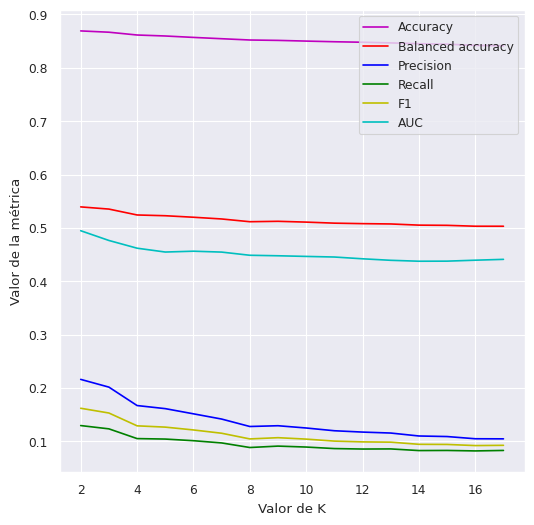

In [9]:
plt.figure(figsize=(6,6))
plt.plot(list(all_features_accs.keys()), list(all_features_accs.values()), color='m', label='Accuracy')
plt.plot(list(all_features_baccs.keys()), list(all_features_baccs.values()), color='r', label='Balanced accuracy')
plt.plot(list(all_features_precs.keys()), list(all_features_precs.values()), color='b', label='Precision')
plt.plot(list(all_features_recs.keys()), list(all_features_recs.values()), color='g', label='Recall')
plt.plot(list(all_features_f1s.keys()), list(all_features_f1s.values()), color='y', label='F1')
plt.plot(list(all_features_aucs.keys()), list(all_features_aucs.values()), color='c', label='AUC')
plt.xlabel('Valor de K')
plt.xticks(range(2,18,2))
plt.ylabel('Valor de la métrica')
#plt.title('Métricas de LOF para distintos K con todas las features')
plt.legend()
#plt.grid()
plt.savefig(f'./Plots/OutlierDetection/LOF_metrics.eps',format='eps',bbox_inches='tight')
plt.show()
plt.close()

#### Métricas y resultados

In [ ]:
print('---------------------------- Local features ----------------------------')
k_local_max_acc, local_max_acc = max(local_features_accs.items(), key=lambda x: x[1])
print(f'Max accuracy with local features:\t\t{local_max_acc:.3f} with {k_local_max_acc} neighbours')
k_local_max_bacc, local_max_bacc = max(local_features_baccs.items(), key=lambda x: x[1])
print(f'Max balanced accuracy with local features:\t{local_max_bacc:.3f} with {k_local_max_bacc} neighbours')
k_local_max_prec, local_max_prec = max(local_features_precs.items(), key=lambda x: x[1])
print(f'Max precision with local features:\t\t{local_max_prec:.3f} with {k_local_max_prec} neighbours')
k_local_max_rec, local_max_rec = max(local_features_recs.items(), key=lambda x: x[1])
print(f'Max recall with local features:\t\t\t{local_max_rec:.3f} with {k_local_max_rec} neighbours')
k_local_max_f1, local_max_f1 = max(local_features_f1s.items(), key=lambda x: x[1])
print(f'Max F1 with local features:\t\t\t{local_max_f1:.3f} with {k_local_max_f1} neighbours')
k_local_max_auc, local_max_auc = max(local_features_aucs.items(), key=lambda x: x[1])
print(f'Max AUC with local features:\t\t\t{local_max_auc:.3f} with {k_local_max_auc} neighbours')
print('')

print('----------------------------- All features -----------------------------')
k_all_max_acc, all_max_acc = max(all_features_accs.items(), key=lambda x: x[1])
print(f'Max accuracy with all features:\t\t\t{all_max_acc:.3f} with {k_all_max_acc} neighbours')
k_all_max_bacc, all_max_bacc = max(all_features_baccs.items(), key=lambda x: x[1])
print(f'Max balanced accuracy with all features:\t{all_max_bacc:.3f} with {k_all_max_bacc} neighbours')
k_all_max_prec, all_max_prec = max(all_features_precs.items(), key=lambda x: x[1])
print(f'Max precision with all features:\t\t{all_max_prec:.3f} with {k_all_max_prec} neighbours')
k_all_max_rec, all_max_rec = max(all_features_recs.items(), key=lambda x: x[1])
print(f'Max recall with all features:\t\t\t{all_max_rec:.3f} with {k_all_max_rec} neighbours')
k_all_max_f1, all_max_f1 = max(all_features_f1s.items(), key=lambda x: x[1])
print(f'Max F1 with all features:\t\t\t{all_max_f1:.3f} with {k_all_max_f1} neighbours')
k_all_max_auc, all_max_auc = max(all_features_aucs.items(), key=lambda x: x[1])
print(f'Max AUC with all features:\t\t\t{all_max_auc:.3f} with {k_all_max_auc} neighbours')

---------------------------- Local features ----------------------------
Max accuracy with local features:		0.833 with 2 neighbours
Max balanced accuracy with local features:	0.491 with 2 neighbours
Max precision with local features:		0.079 with 2 neighbours
Max recall with local features:			0.067 with 4 neighbours
Max F1 with local features:			0.072 with 2 neighbours
Max AUC with local features:			0.475 with 2 neighbours

----------------------------- All features -----------------------------
Max accuracy with all features:			0.860 with 2 neighbours
Max balanced accuracy with all features:	0.542 with 2 neighbours
Max precision with all features:		0.201 with 2 neighbours
Max recall with all features:			0.147 with 2 neighbours
Max F1 with all features:			0.170 with 2 neighbours
Max AUC with all features:			0.495 with 2 neighbours


Podemos observar que las *features* agregadas nos proporcionan "unas décimas" en la mayoría de métricas a la hora de detectar *outliers*.

Aunque se obtienen valores de *accuracy* de hasta 0.86, las métricas que más interesan para este problema de clasificación son aquellas que tienen en cuenta la cantidad de falsos positivos y falsos negativos, y puesto que el dataset se encuentra altamente desbalanceado, la *accuracy* puede ser una métrica engañosa.

Por tanto el valor de $K$ con el que se obtienen mejores resultados en términos generales es $K=2$, lo que indica que el dataset tiene una alta sensibilidad *outliers* locales.

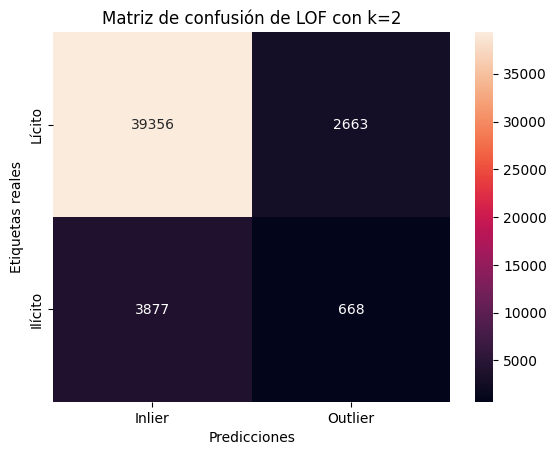

In [ ]:
plot_cm(all_features_preds[2])

## Pruebas con distinto número de componentes reducidad por PCA

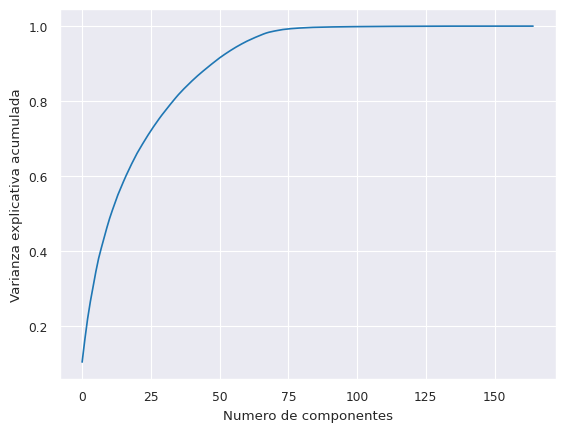

In [ ]:
pca_reduced_feat, _ = compute_pca(df_transactions.iloc[:,3:])

  0%|          | 0/12 [00:00<?, ?it/s]

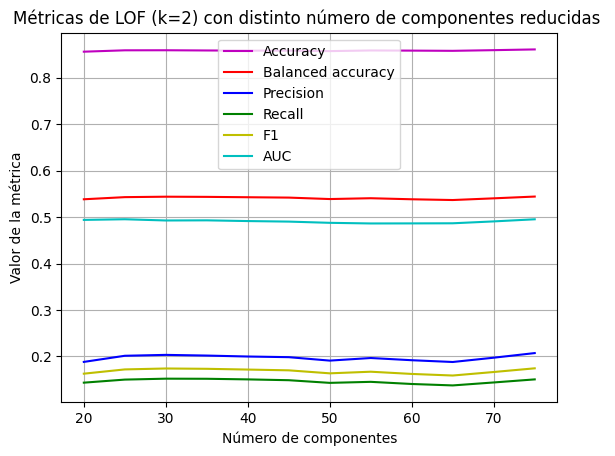

In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from tqdm.notebook import tqdm

reduced_features_preds = dict()
reduced_features_accs = dict()
reduced_features_baccs = dict()
reduced_features_precs = dict()
reduced_features_recs = dict()
reduced_features_f1s = dict()
reduced_features_aucs = dict()
reduced_features_lofs = dict()

for n in tqdm(range(20,76,5)):
    X = pca_reduced_feat[:,:n]
    clf = LocalOutlierFactor(n_neighbors=2, contamination=positive_prop)
    all_predicted_flags = clf.fit_predict(X)
    all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                                np.where(all_predicted_flags == 1, 0, all_predicted_flags))
    predicted_flags = all_predicted_flags[df_known.index]
    reduced_features_preds[n] = predicted_flags
    reduced_features_lofs[n] = -clf.negative_outlier_factor_[df_known.index]
    reduced_features_accs[n] = accuracy_score(test_flags,predicted_flags)
    reduced_features_baccs[n] = balanced_accuracy_score(test_flags,predicted_flags)
    reduced_features_precs[n] = precision_score(test_flags,predicted_flags)
    reduced_features_recs[n] = recall_score(test_flags,predicted_flags)
    reduced_features_f1s[n] = f1_score(test_flags,predicted_flags)
    reduced_features_aucs[n] = roc_auc_score(test_flags,reduced_features_lofs[n])

plt.plot(list(reduced_features_accs.keys()), list(reduced_features_accs.values()), color='m', label='Accuracy')
plt.plot(list(reduced_features_baccs.keys()), list(reduced_features_baccs.values()), color='r', label='Balanced accuracy')
plt.plot(list(reduced_features_precs.keys()), list(reduced_features_precs.values()), color='b', label='Precision')
plt.plot(list(reduced_features_recs.keys()), list(reduced_features_recs.values()), color='g', label='Recall')
plt.plot(list(reduced_features_f1s.keys()), list(reduced_features_f1s.values()), color='y', label='F1')
plt.plot(list(reduced_features_aucs.keys()), list(reduced_features_aucs.values()), color='c', label='AUC')
plt.xlabel('Número de componentes')
plt.ylabel('Valor de la métrica')
plt.title('Métricas de LOF (k=2) con distinto número de componentes reducidas ')
plt.legend()
plt.grid()
plt.show()

Puntuación F1 máxima de LOF (K=2): 0.17454452796534592 con 75 features reducidas


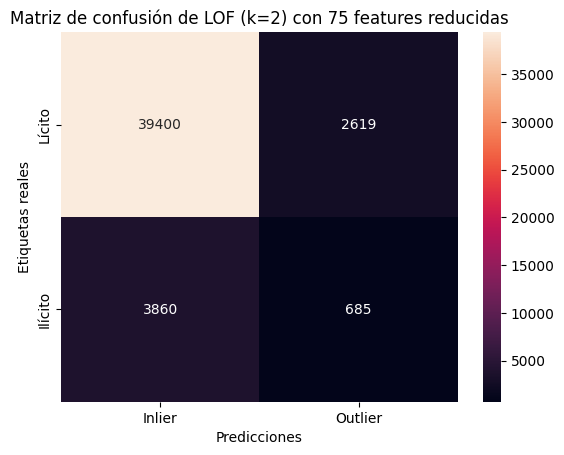

In [ ]:
n_feat_reduced_max_f1, reduced_max_f1 = max(reduced_features_f1s.items(), key=lambda x: x[1])
print(f'Puntuación F1 máxima de LOF (K=2): {reduced_max_f1} con {n_feat_reduced_max_f1} features reducidas')
plot_cm(reduced_features_preds[n_feat_reduced_max_f1])

# **5. *Isolation Forest (ISOF)***
---

## Pruebas con todas las *features* para encontrar el mejor número de estimadores


Gracias al parámetro ```warm_start``` se pueden ir añadiendo estimadores al modelo una vez este ya se ha ajustado.

  0%|          | 0/9 [00:00<?, ?it/s]

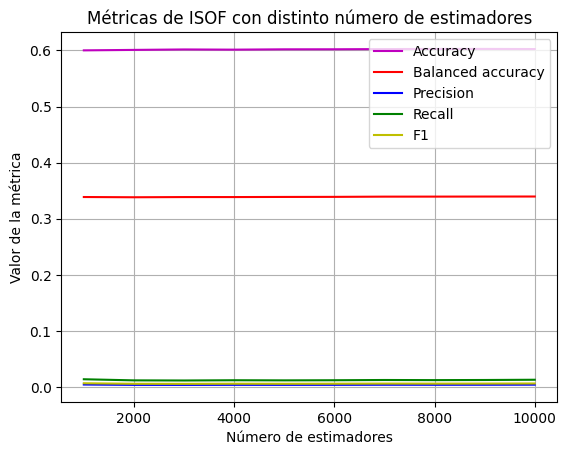

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.ensemble import IsolationForest
from tqdm.notebook import tqdm

X = df_transactions.drop(['txId', 'timestep', 'class'], axis=1)

isof_preds = dict()
isof_accs = dict()
isof_baccs = dict()
isof_precs = dict()
isof_recs = dict()
isof_f1s = dict()

#isof = IsolationForest(n_estimators=100, contamination=positive_prop, max_samples=1.0, warm_start=True)
isof = IsolationForest(n_estimators=1000, contamination=positive_prop, n_jobs=-1, warm_start=True)
all_predicted_flags = isof.fit_predict(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
isof_preds[1000] = predicted_flags
isof_accs[1000] = accuracy_score(test_flags,predicted_flags)
isof_baccs[1000] = balanced_accuracy_score(test_flags,predicted_flags)
isof_precs[1000] = precision_score(test_flags,predicted_flags)
isof_recs[1000] = recall_score(test_flags,predicted_flags)
isof_f1s[1000] = f1_score(test_flags,predicted_flags)

for n in tqdm(range(2000,10001,1000)):
    isof.set_params(n_estimators=n)
    all_predicted_flags = isof.fit_predict(X)
    all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                                np.where(all_predicted_flags == 1, 0, all_predicted_flags))
    predicted_flags = all_predicted_flags[df_known.index]
    isof_preds[n] = predicted_flags
    isof_accs[n] = accuracy_score(test_flags,predicted_flags)
    isof_baccs[n] = balanced_accuracy_score(test_flags,predicted_flags)
    isof_precs[n] = precision_score(test_flags,predicted_flags)
    isof_recs[n] = recall_score(test_flags,predicted_flags)
    isof_f1s[n] = f1_score(test_flags,predicted_flags)

plt.plot(list(isof_accs.keys()), list(isof_accs.values()), color='m', label='Accuracy')
plt.plot(list(isof_baccs.keys()), list(isof_baccs.values()), color='r', label='Balanced accuracy')
plt.plot(list(isof_precs.keys()), list(isof_precs.values()), color='b', label='Precision')
plt.plot(list(isof_recs.keys()), list(isof_recs.values()), color='g', label='Recall')
plt.plot(list(isof_f1s.keys()), list(isof_f1s.values()), color='y', label='F1')
plt.xlabel('Número de estimadores')
plt.ylabel('Valor de la métrica')
plt.title('Métricas de ISOF con distinto número de estimadores')
plt.legend()
plt.grid()
plt.show()

Se puede observar que un mayor número de estimadores no mejora los resultados del algoritmo.

## Pruebas con *features* reducidas por PCA

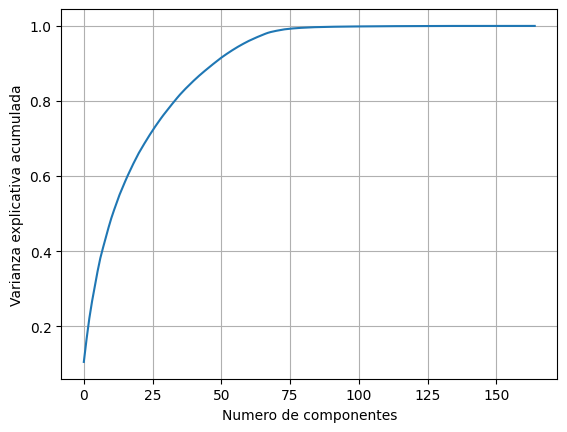

In [ ]:
pca_reduced_feat, _ = compute_pca(df_transactions.iloc[:,3:])
reduced_feature_matrix = pca_reduced_feat[:,:75]

Accuracy: 0.6439094579503479
Balanced accuracy: 0.36835624755745283
Precision: 0.009615384615384616
Recall: 0.025962596259625964
F1 score: 0.014033418564547779


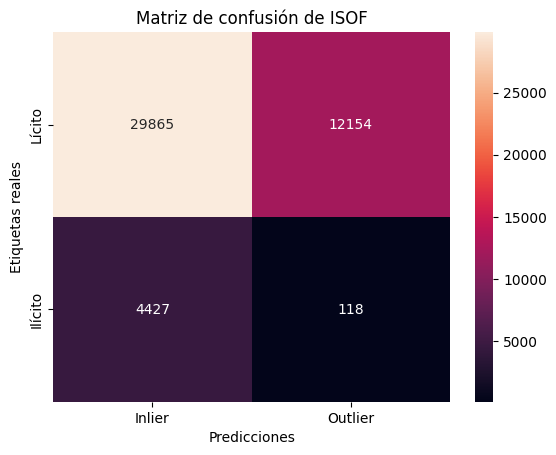

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.ensemble import IsolationForest
from tqdm.notebook import tqdm

X = reduced_feature_matrix

isof = IsolationForest(n_estimators=1000, contamination=positive_prop, n_jobs=-1)
all_predicted_flags = isof.fit_predict(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
print(f'Accuracy: {accuracy_score(test_flags,predicted_flags)}')
print(f'Balanced accuracy: {balanced_accuracy_score(test_flags,predicted_flags)}')
print(f'Precision: {precision_score(test_flags,predicted_flags)}')
print(f'Recall: {recall_score(test_flags,predicted_flags)}')
print(f'F1 score: {f1_score(test_flags,predicted_flags)}')
plot_cm(predicted_flags, title='Matriz de confusión de ISOF')

## Pruebas finales

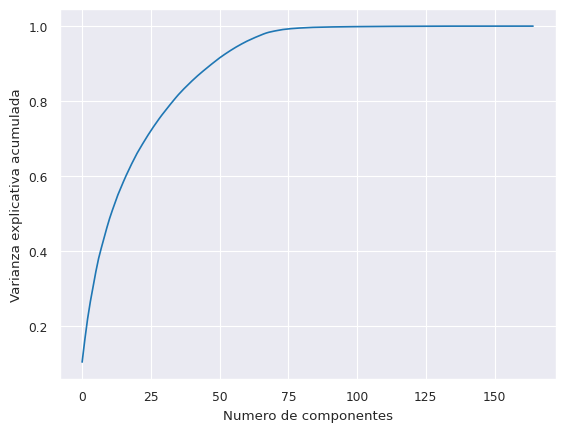

In [ ]:
pca_reduced_feat, _ = compute_pca(df_transactions.iloc[:,3:])
reduced_feature_matrix = pca_reduced_feat[:,:75]

---
---
&nbsp;

&nbsp;
# Pruebas finales
---
---

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.set_context('paper')
!mkdir -p ./Plots/OutlierDetection/

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def compute_pca(feature_matrix, plot=False, save=False):
    pca = PCA()
    reduced_features = pca.fit_transform(feature_matrix)
    expl = pca.explained_variance_ratio_

    if plot:
        plt.figure(figsize=(6,6))
        plt.plot(np.cumsum(expl))
        plt.xlabel('Numero de componentes')
        plt.ylabel('Varianza explicativa acumulada')
        if save:
            plt.savefig(f'./Plots/OutlierDetection/PCA_expl.eps',format='eps',bbox_inches='tight')
        plt.show()

    return reduced_features, expl


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

def plot_cm(predictions, filename=None):
    global test_flags

    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(test_flags, predictions), annot=True, fmt='d',
                xticklabels=['Inlier', 'Outlier'],
                yticklabels=['Lícito', 'Ilícito'])
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas reales')
    if filename is not None:
        plt.savefig(f'./Plots/OutlierDetection/{filename}_cm.eps',format='eps',bbox_inches='tight')
    plt.show()
    plt.close()


## *LOF*

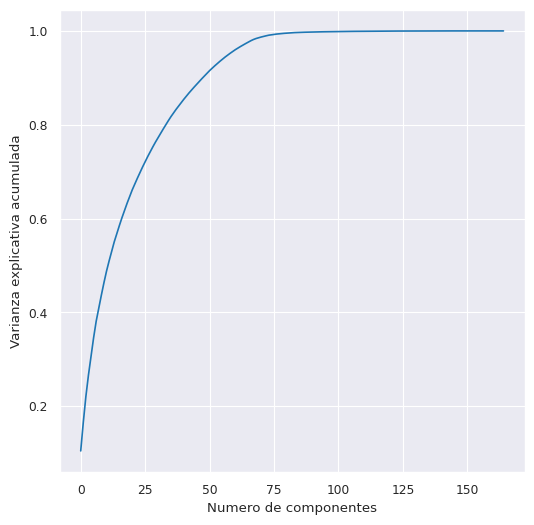

In [12]:
pca_reduced_feat, _ = compute_pca(df_transactions.iloc[:,3:], plot=True, save=True)

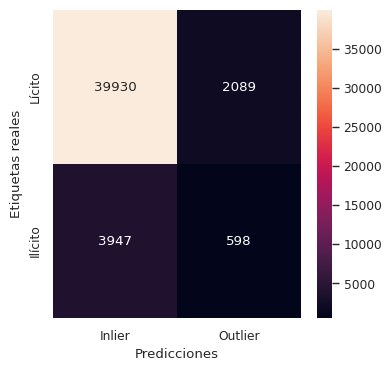


              precision    recall  f1-score   support

       Licit       0.91      0.95      0.93     42019
     Illicit       0.22      0.13      0.17      4545

    accuracy                           0.87     46564
   macro avg       0.57      0.54      0.55     46564
weighted avg       0.84      0.87      0.86     46564


ROC AUC Score: 0.495


In [13]:
from sklearn.neighbors import LocalOutlierFactor

X = pca_reduced_feat[:,:75]
lof = LocalOutlierFactor(n_neighbors=2, contamination=positive_prop)
all_predicted_flags = lof.fit_predict(X)
all_scores = -lof.negative_outlier_factor_
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                               np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
predicted_scores = all_scores[df_known.index]

plot_cm(predicted_flags, filename='lof_pca_k2')
report = classification_report(test_flags, predicted_flags, target_names=['Licit', 'Illicit'])
auc = roc_auc_score(test_flags, predicted_scores)
print('')
print(report)
print(f'\nROC AUC Score: {auc:.3f}')
with open('./Plots/OutlierDetection/lof_pca_k2.txt', 'w') as report_file:
    report_file.write(report)
    report_file.write(f'\nROC AUC Score: {auc:.3f}')

## *ISOF*

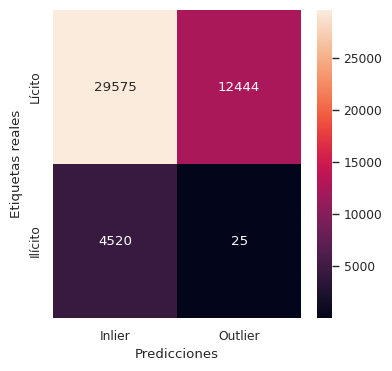


              precision    recall  f1-score   support

       Licit       0.87      0.70      0.78     42019
     Illicit       0.00      0.01      0.00      4545

    accuracy                           0.64     46564
   macro avg       0.43      0.35      0.39     46564
weighted avg       0.78      0.64      0.70     46564


ROC AUC Score: 0.097


In [14]:
from sklearn.ensemble import IsolationForest

X = df_transactions.drop(['txId', 'timestep', 'class'], axis=1)
isof = IsolationForest(n_estimators=1000, contamination=positive_prop, n_jobs=-1)
all_predicted_flags = isof.fit_predict(X)
all_scores = -isof.score_samples(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
predicted_scores = all_scores[df_known.index]

plot_cm(predicted_flags, filename='isof_all_features_n1000')
report = classification_report(test_flags, predicted_flags, target_names=['Licit', 'Illicit'])
auc = roc_auc_score(test_flags, predicted_scores)
print('')
print(report)
print(f'\nROC AUC Score: {auc:.3f}')
with open('./Plots/OutlierDetection/isof_all_features_n1000.txt', 'w') as report_file:
    report_file.write(report)
    report_file.write(f'\nROC AUC Score: {auc:.3f}')

## *One Class SVM*

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_transactions.drop(['txId', 'timestep', 'class'], axis=1))

In [ ]:
from sklearn.svm import OneClassSVM

oc_svm = OneClassSVM()
all_predicted_flags = oc_svm.fit_predict(X)
all_scores = -oc_svm.score_samples(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
predicted_scores = all_scores[df_known.index]

plot_cm(predicted_flags, filename='ocsvm_scaled_features')
report = classification_report(test_flags, predicted_flags, target_names=['Licit', 'Illicit'])
auc = roc_auc_score(test_flags, predicted_scores)
print('')
print(report)
print(f'\nROC AUC Score: {auc:.3f}')
with open('./Plots/OutlierDetection/ocsvm_scaled_features.txt', 'w') as report_file:
    report_file.write(report)
    report_file.write(f'\nROC AUC Score: {auc:.3f}')

KeyboardInterrupt: 

## *SGD One Class SVM*

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_transactions.drop(['txId', 'timestep', 'class'], axis=1))

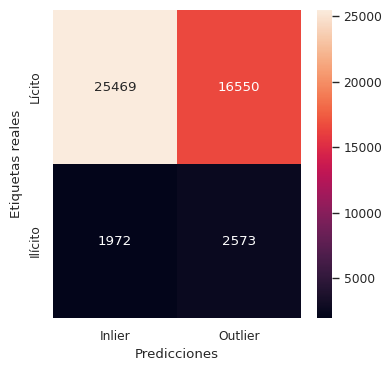


              precision    recall  f1-score   support

       Licit       0.93      0.61      0.73     42019
     Illicit       0.13      0.57      0.22      4545

    accuracy                           0.60     46564
   macro avg       0.53      0.59      0.48     46564
weighted avg       0.85      0.60      0.68     46564


ROC AUC Score: 0.627


In [13]:
from sklearn.linear_model import SGDOneClassSVM

sgd_oc_svm = SGDOneClassSVM()
all_predicted_flags = sgd_oc_svm.fit_predict(X)
all_scores = -sgd_oc_svm.score_samples(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
predicted_scores = all_scores[df_known.index]

plot_cm(predicted_flags, filename='sgdocsvm_scaled_features')
report = classification_report(test_flags, predicted_flags, target_names=['Licit', 'Illicit'])
auc = roc_auc_score(test_flags, predicted_scores)
print('')
print(report)
print(f'\nROC AUC Score: {auc:.3f}')
with open('./Plots/OutlierDetection/sgdocsvm_scaled_features.txt', 'w') as report_file:
    report_file.write(report)
    report_file.write(f'\nROC AUC Score: {auc:.3f}')

## *Elliptic Envelope*

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_transactions.drop(['txId', 'timestep', 'class'], axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4182.599075321583769 > -5132.270249463713299). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4667.064924642991173 > -6490.224300350853810). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: l

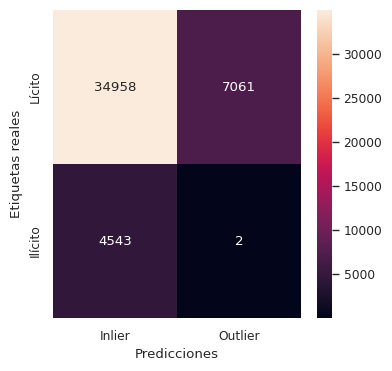


              precision    recall  f1-score   support

       Licit       0.88      0.83      0.86     42019
     Illicit       0.00      0.00      0.00      4545

    accuracy                           0.75     46564
   macro avg       0.44      0.42      0.43     46564
weighted avg       0.80      0.75      0.77     46564


ROC AUC Score: 0.175


In [16]:
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(assume_centered=True, contamination=positive_prop)
all_predicted_flags = ee.fit_predict(X)
all_scores = -ee.score_samples(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
predicted_scores = all_scores[df_known.index]

plot_cm(predicted_flags, filename='ee_scaled_features')
report = classification_report(test_flags, predicted_flags, target_names=['Licit', 'Illicit'])
auc = roc_auc_score(test_flags, predicted_scores)
print('')
print(report)
print(f'\nROC AUC Score: {auc:.3f}')
with open('./Plots/OutlierDetection/ee_scaled_features.txt', 'w') as report_file:
    report_file.write(report)
    report_file.write(f'\nROC AUC Score: {auc:.3f}')

---
---

# Pruebas...

### *Forward Greedy feature selection*

### *Backward Greedy feature selection*

En cada iteración se va a evaluar el estimador LOF de 2 vecinos con una *feature* menos, escogida de tal manera que el modelo obtenga una puntuación F1 mejor a las anteriores. Para ello, se probará primero a eliminar la *feature* con menor información mutua, hasta obtener una mejor métrica.

In [ ]:

selected_features =
X = df_transactions.drop(['txId', 'Time step', 'class'], axis=1)

def drop_less_important_feature():
    i = 0


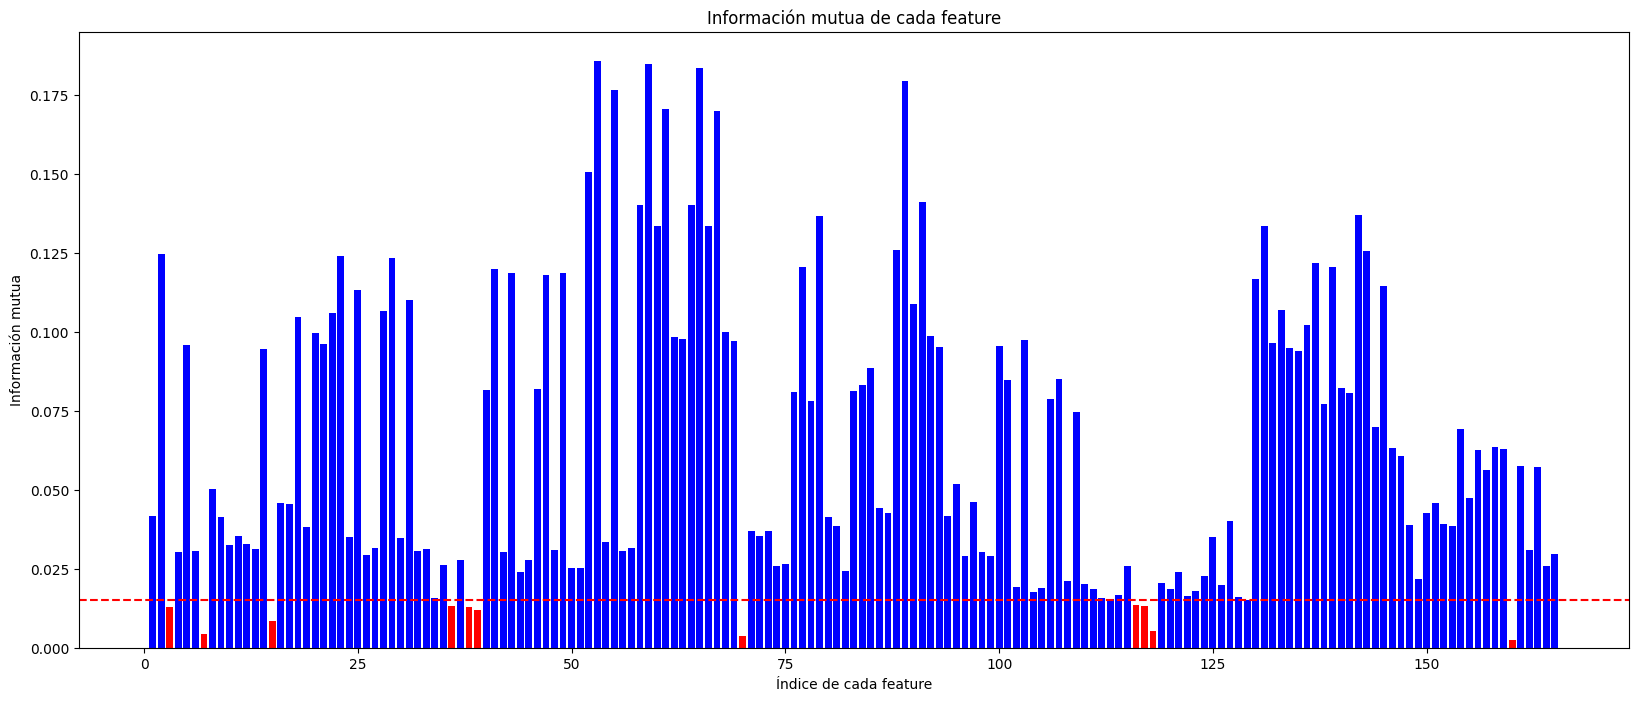

Eliminadas 11 features


In [ ]:
mi_threshold = 0.015
colors = ['r' if mi < mi_threshold else 'b' for mi in mis]
fig = plt.figure(figsize = (20, 8))
plt.bar([i+1 for i in range(feat.shape[1])], mis, color = colors)
plt.axhline(y=mi_threshold, color='r', linestyle='--')
plt.xlabel("Índice de cada feature")
plt.ylabel("Información mutua")
plt.title("Información mutua de cada feature")
plt.show()

col_mask = [False if mi < mi_threshold else True for mi in mis]
print(f'Eliminadas {col_mask.count(False)} features')

Puntuación F1: 0.16041826064779394


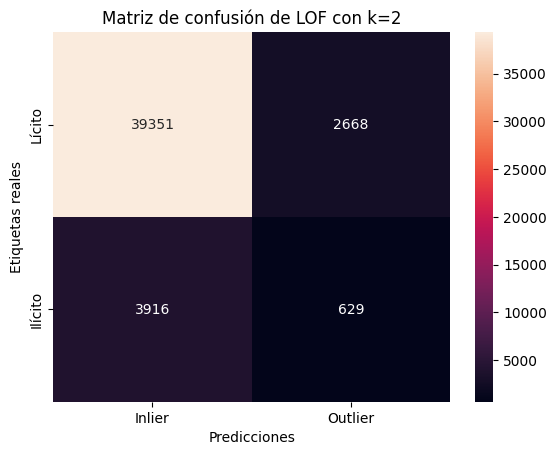

In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.neighbors import LocalOutlierFactor

X = df_transactions.drop(['txId', 'Time step', 'class'], axis=1)
X = X[X.columns[col_mask]]

clf = LocalOutlierFactor(n_neighbors=2, contamination=positive_prop)
all_predicted_flags = clf.fit_predict(X)
all_predicted_flags = np.where(all_predicted_flags == -1, 1,
                            np.where(all_predicted_flags == 1, 0, all_predicted_flags))
predicted_flags = all_predicted_flags[df_known.index]
print(f'Puntuación F1: {f1_score(test_flags, predicted_flags)}')
plot_cm(predicted_flags, k=2)

In [ ]:
#@title #### Requisitos
!pip install scikit-learn
!pip install matplotlib
!pip install pycm

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve
from pycm import ConfusionMatrix
from tqdm.notebook import tqdm

## **Algoritmos de detección de anomalías para grafos**

### Requisitos

In [ ]:
#@title #### Instalación de *torch geometric*

!pip install torch_geometric
# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html


In [ ]:
#@title #### Instalación de *PyGOD*

!pip install pygod

### Generación del dataset de tipo `torch_geometric.data.Data`

# **3. Preprocesado de los datos**

## 3.1 Normalización

In [ ]:
from sklearn.preprocessing import normalize

normalized_features = normalize(df_features.iloc[:,2:].values, axis=0)
df_features_normalized = pd.DataFrame(normalized_features, columns=[f'Feature {i}' for i in range(1, 166)])
df_features_normalized['txId'] = df_features.iloc[:,0]
df_features_normalized['Time step'] = df_features.iloc[:,1]

df_transactions = pd.merge(df_classes, df_features_normalized, on='txId', how='inner')

## 3.3. *Feature Engineering*

### Eliminación de *Features* con **Varianza** nula


In [ ]:
from sklearn.feature_selection import VarianceThreshold

X = df_transactions.drop(['txId', 'Time step', 'class'], axis=1)
n_prev_features = X.shape[1]
var = VarianceThreshold()   # Por defecto elimina features con Varianza 0
X = var.fit_transform(X)
n_post_features = X.shape[1]
print(f'Eliminadas {n_post_features-n_prev_features} con varianza nula')

Eliminadas 0 con varianza nula
